# GSE74310 - scATAC-Seq SPAN, MACS2 vs DNAse hypersensitive sites

Before launch corresponding .
```
git checkout https://github.com/JetBrains-Research/sc-atacseq-smk-pipeline
cd /mnt/stripe/shpynov/sc-atacseq-smk-pipeline

for Q in 0.1 0.5 0.01 1E-4 1E-6 1E-9 1E-12; do 
    echo $Q; 
    snakemake all --cores 24 --use-conda --config work_dir=~/data/GSE74310/ \
        fastq_dir=~/data/GSE74310/fastq/  indexes=~/data/issue75/indexes2/hg19 \
        macs2_suffix="q${Q}" macs2_stats="-q ${Q}"; 
done
```


In [1]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
import os;
from pybedtools import BedTool;
import subprocess;
import math;

In [41]:
CELLS = ["Monocyte", 
         "acute_myeloid_leukemia_blast_cell", 
         "acute_myeloid_leukemia_leukmeia_stem_cell", 
         "lymphoid_primed_multipotent_progenitor"]
CELLS.append('total_pooled_data')
EXPERIMENT_FOLDER = "~/data/GSE74310"
# Switch to the same Q values as SPAN
# MACS2_PS = ["0.001", "0.0001", "0.00001"]
# Use same settings as for SPAN
QS = ["0.5", "0.1", "0.01", "1E-4", "1E-6", "1E-9", "1E-12"]
MACS2_QS = QS
# discover MACS2 peak files
macs2_peaks_paths = {}
for cell in CELLS:
    macs2_peaks_paths[cell] = {
        q: os.path.join(EXPERIMENT_FOLDER, "cleaned_cell_peaks", "macs2",
                        "{}_q{}_peaks.narrowPeak".format(cell, q)) for q in MACS2_QS}
macs2_peaks_paths["total_pooled_data"] = {
    q: os.path.join(EXPERIMENT_FOLDER, "cleaned_all_peaks", "macs2",
                    "pooled_q{}_peaks.narrowPeak".format(q)) for q in MACS2_QS}

# discover Span model files and BAMs
SPAN_BINS = ["100"]
span_model_paths = {}
bam_paths = {}
for cell in CELLS:
    bam_paths[cell] = os.path.join(EXPERIMENT_FOLDER, "cleaned_cells", "{}.bam".format(cell))
    span_model_paths[cell] = {span_bin: os.path.join(EXPERIMENT_FOLDER, "cleaned_cell_peaks", "span", "{}_{}.span".format(cell, span_bin)) for span_bin in SPAN_BINS}
bam_paths["total_pooled_data"] = os.path.join(EXPERIMENT_FOLDER, "cleaned_all", "pooled.bam")
span_model_paths["total_pooled_data"] = {span_bin: os.path.join(EXPERIMENT_FOLDER, "cleaned_all_peaks", "span", "pooled_{}.span".format(span_bin)) for span_bin in SPAN_BINS}
SPAN_JAR = os.path.join(EXPERIMENT_FOLDER, "bin", "span-0.11.0.jar")


# discover monocyte DHSs
# Monocytes DHS was obtained from https://www.encodeproject.org/experiments/ENCSR000EPK/
# hg19 representative DHS sites: https://www.encodeproject.org/annotations/ENCSR664FOJ/
monocyte_dhs_file = BedTool(os.path.join(EXPERIMENT_FOLDER, "dhs", "monocyte_cd14_dnase_tab.bed"))
dhs_hg19 = BedTool(os.path.join(EXPERIMENT_FOLDER, "dhs", "hg19.bed"))
CHROM_SIZES = os.path.join(EXPERIMENT_FOLDER, "hg19.chrom.sizes")

In [42]:
main_dataframe = pd.DataFrame(columns=['peak_caller', 'cell', 'q', 'bin', 'gap',
                                       'peak_count', 'dhs_by_peak', 'peak_by_dhs'])

# Populate MACS2 entries

In [46]:
for cell in CELLS:
    for q in MACS2_QS:
        print("Processing {} for q={}".format(cell, q))
        peaks_file = BedTool(macs2_peaks_paths[cell][q])
        peak_count = peaks_file.count()
        dhs_file = monocyte_dhs_file if cell == 'Monocyte' else dhs_hg19
        overlap = peaks_file.intersect(dhs_file, wa=True, u=True).count()
        peak_by_dhs = overlap * 100.0 / peak_count            
        overlap = dhs_file.intersect(peaks_file, wa=True, u=True).count()
        dhs_by_peak = overlap * 100.0 / dhs_file.count()
        main_dataframe.loc[len(main_dataframe)] = ('macs2', cell, float(q), math.nan, math.nan,
                                                   peak_count, dhs_by_peak, peak_by_dhs)
main_dataframe.head()

Processing Monocyte for q=0.5
Processing Monocyte for q=0.1
Processing Monocyte for q=0.01
Processing Monocyte for q=1E-4
Processing Monocyte for q=1E-6
Processing Monocyte for q=1E-9
Processing Monocyte for q=1E-12
Processing acute_myeloid_leukemia_blast_cell for q=0.5
Processing acute_myeloid_leukemia_blast_cell for q=0.1
Processing acute_myeloid_leukemia_blast_cell for q=0.01
Processing acute_myeloid_leukemia_blast_cell for q=1E-4
Processing acute_myeloid_leukemia_blast_cell for q=1E-6
Processing acute_myeloid_leukemia_blast_cell for q=1E-9
Processing acute_myeloid_leukemia_blast_cell for q=1E-12
Processing acute_myeloid_leukemia_leukmeia_stem_cell for q=0.5
Processing acute_myeloid_leukemia_leukmeia_stem_cell for q=0.1
Processing acute_myeloid_leukemia_leukmeia_stem_cell for q=0.01
Processing acute_myeloid_leukemia_leukmeia_stem_cell for q=1E-4
Processing acute_myeloid_leukemia_leukmeia_stem_cell for q=1E-6
Processing acute_myeloid_leukemia_leukmeia_stem_cell for q=1E-9
Processing 

,peak_caller,cell,q,bin,gap,peak_count,dhs_by_peak,peak_by_dhs
0,macs2,Monocyte,0.500000,NaN,NaN,57988,34.757700,52.497068
1,macs2,Monocyte,0.100000,NaN,NaN,21311,22.578532,92.027591
2,macs2,Monocyte,0.010000,NaN,NaN,21311,22.578532,92.027591
3,macs2,Monocyte,0.000100,NaN,NaN,10981,12.235933,99.071123
4,macs2,Monocyte,0.000001,NaN,NaN,8675,9.616879,99.596542


# Populate Span entries

In [53]:
SPAN_FDRS = QS
SPAN_GAPS = ["5"]
for cell in CELLS:
    bam_path = bam_paths[cell]
    for span_bin in SPAN_BINS:    
        model_path = span_model_paths[cell][span_bin]
        work_dir = os.path.dirname(model_path)
        for span_fdr in SPAN_FDRS:
            for span_gap in SPAN_GAPS:
                peaks_path = "/tmp/span_peaks.bed"
                command = ('java -jar {} analyze -t {} --chrom.sizes {} --model {} --bin {} '
                           '--keep-dup true --fragment 0 '
                           '--fdr {} --gap {} --peaks {} --workdir {} --threads 8').format(
                    SPAN_JAR, bam_path, CHROM_SIZES, model_path, span_bin, span_fdr, span_gap, peaks_path, work_dir)
                print('Running ' + command)
                subprocess.run(command, shell=True, check=True)
                peaks_file = BedTool(peaks_path)
                peak_count = peaks_file.count()
                print(peak_count)
                dhs_file = monocyte_dhs_file if cell == 'Monocyte' else dhs_hg19
                overlap = peaks_file.intersect(dhs_file, wa=True, u=True).count()
                peak_by_dhs = overlap * 100.0 / peak_count            
                overlap = dhs_file.intersect(peaks_file, wa=True, u=True).count()
                dhs_by_peak = overlap * 100.0 / dhs_file.count()
                main_dataframe.loc[len(main_dataframe)] = \
                ('span', cell, float(span_fdr), int(span_bin), 
                 int(span_gap), peak_count, dhs_by_peak, peak_by_dhs)

Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.11.0.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/Monocyte.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span/Monocyte_100.span --bin 100 --keep-dup true --fragment 0 --fdr 0.5 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span --threads 8
54777
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.11.0.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/Monocyte.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span/Monocyte_100.span --bin 100 --keep-dup true --fragment 0 --fdr 0.1 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span --threads 8
32758
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.11.0.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/M

230877
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.11.0.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_leukmeia_stem_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span/acute_myeloid_leukemia_leukmeia_stem_cell_100.span --bin 100 --keep-dup true --fragment 0 --fdr 1E-6 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span --threads 8
230877
Running java -jar /mnt/stripe/dievsky/GSE74310/bin/span-0.11.0.jar analyze -t /mnt/stripe/dievsky/GSE74310/cleaned_cells/acute_myeloid_leukemia_leukmeia_stem_cell.bam --chrom.sizes /mnt/stripe/dievsky/GSE74310/hg19.chrom.sizes --model /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/span/acute_myeloid_leukemia_leukmeia_stem_cell_100.span --bin 100 --keep-dup true --fragment 0 --fdr 1E-9 --gap 5 --peaks /tmp/span_peaks.bed --workdir /mnt/stripe/dievsky/GSE74310/cleaned_cell_peaks/spa

In [61]:
main_dataframe.describe()

,q,bin,gap,dhs_by_peak,peak_by_dhs
count,7.000000e+01,35.0,35.0,70.000000,70.000000
mean,8.715729e-02,100.0,5.0,8.883698,86.803193
std,1.731738e-01,0.0,0.0,9.574741,13.032553
min,1.000000e-12,100.0,5.0,0.101546,52.497068
25%,1.000000e-09,100.0,5.0,1.630927,73.389388
50%,1.000000e-04,100.0,5.0,7.512788,92.090633
75%,1.000000e-01,100.0,5.0,12.124664,98.767590
max,5.000000e-01,100.0,5.0,46.838185,99.934660


In [62]:
overlap_dataframe = main_dataframe[np.logical_not(np.isnan(main_dataframe['dhs_by_peak']))]
overlap_dataframe.describe()

,q,bin,gap,dhs_by_peak,peak_by_dhs
count,7.000000e+01,35.0,35.0,70.000000,70.000000
mean,8.715729e-02,100.0,5.0,8.883698,86.803193
std,1.731738e-01,0.0,0.0,9.574741,13.032553
min,1.000000e-12,100.0,5.0,0.101546,52.497068
25%,1.000000e-09,100.0,5.0,1.630927,73.389388
50%,1.000000e-04,100.0,5.0,7.512788,92.090633
75%,1.000000e-01,100.0,5.0,12.124664,98.767590
max,5.000000e-01,100.0,5.0,46.838185,99.934660


# Plot DHS overlap
NOTE: there is information only about the monocytes

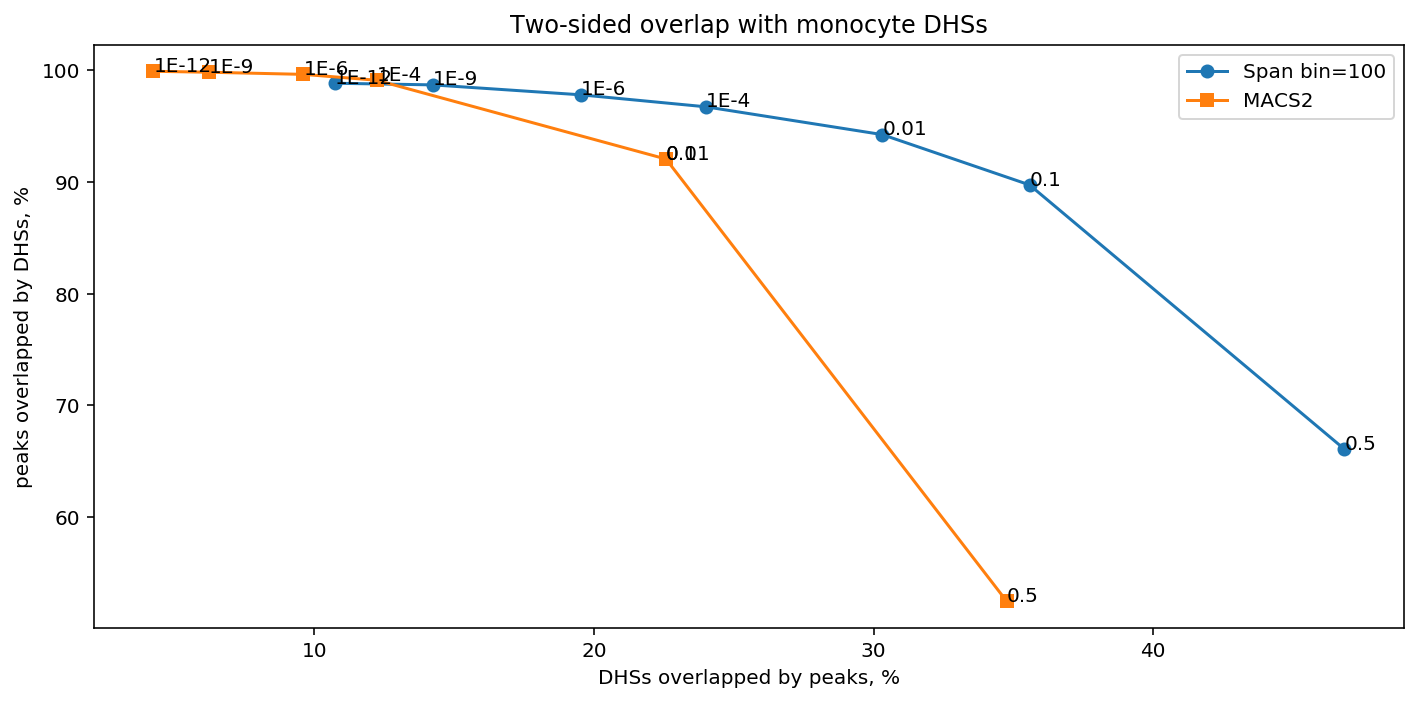

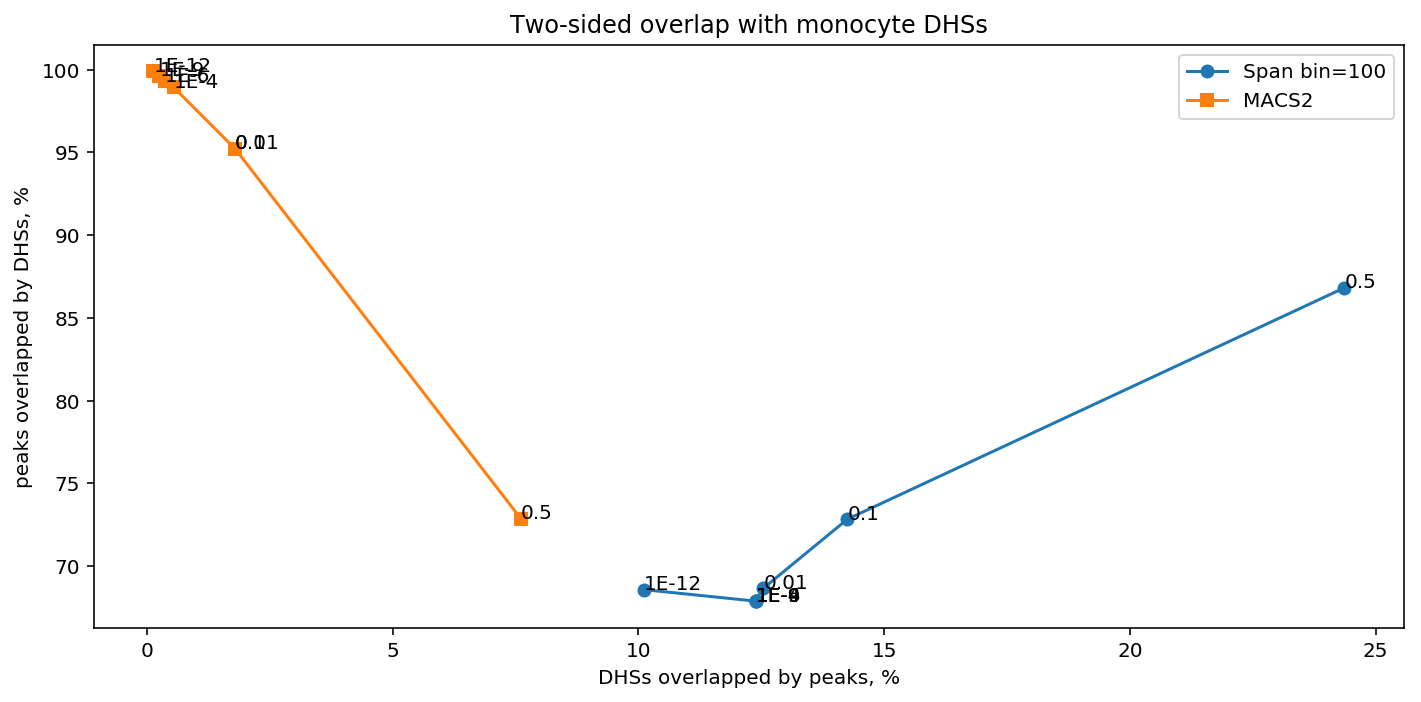

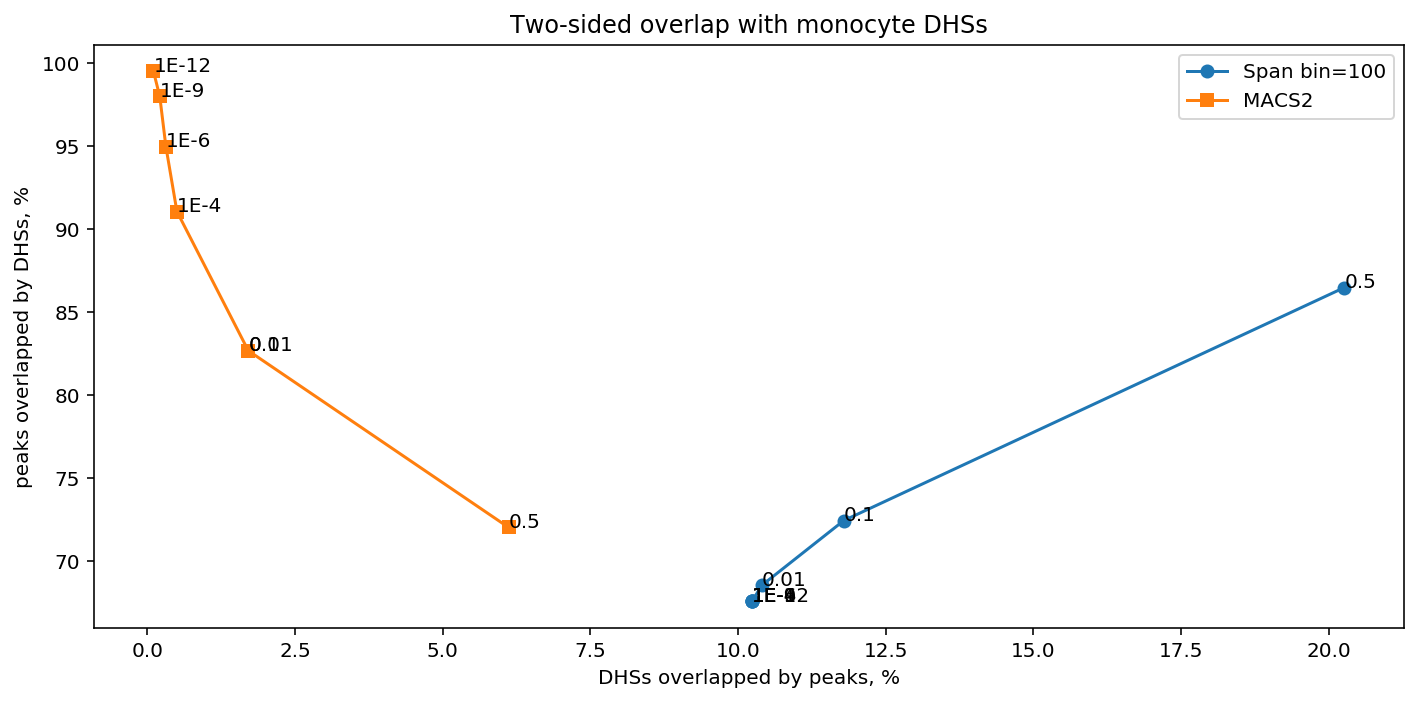

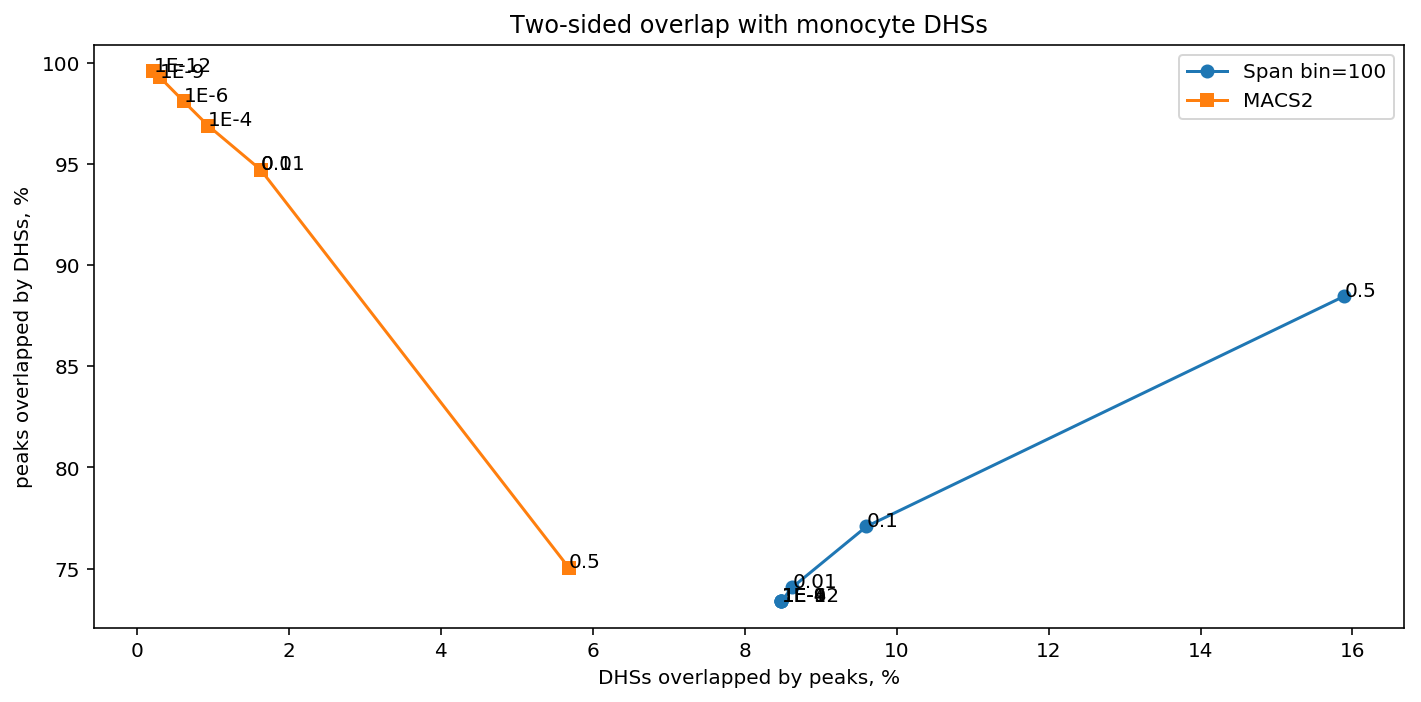

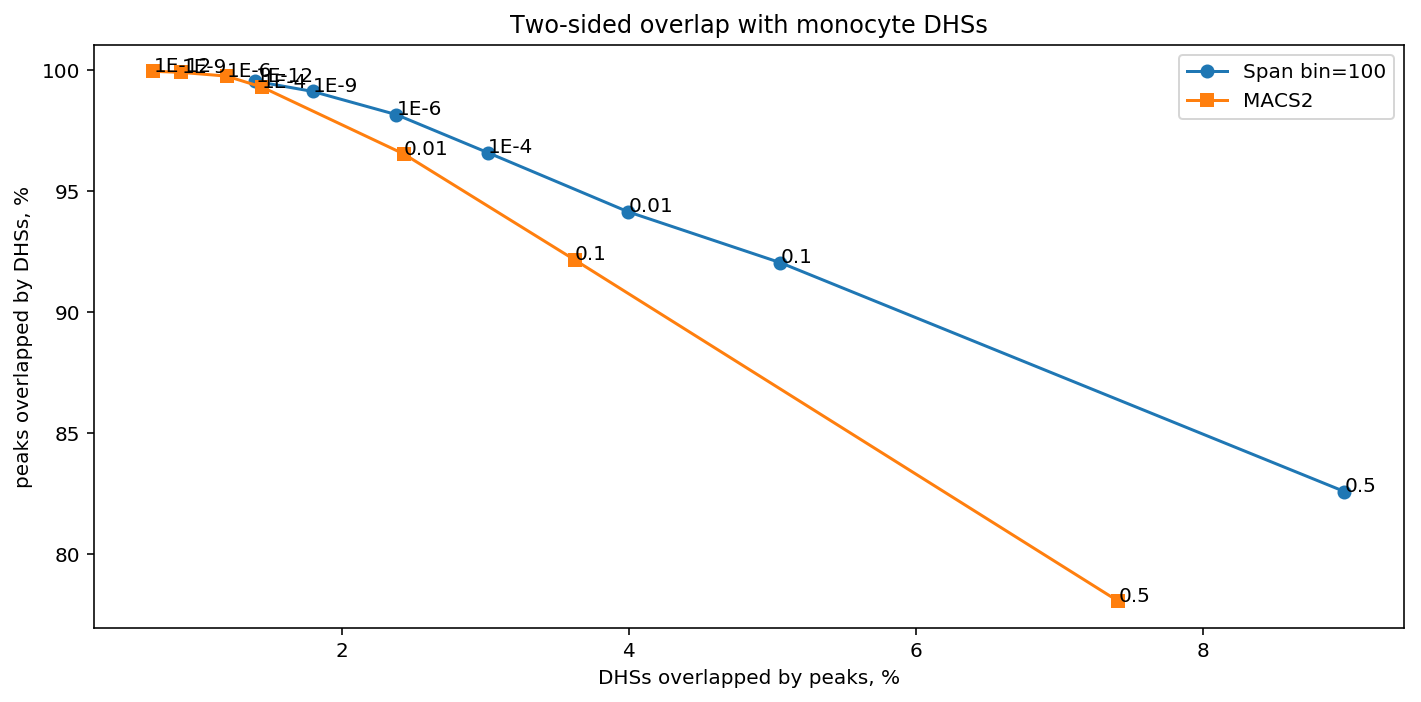

In [63]:
for cell in CELLS:
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    for span_bin in SPAN_BINS:
        span_overlap_dataframe = \
        overlap_dataframe[np.logical_and(overlap_dataframe['cell'] == cell,
        np.logical_and(np.logical_and(overlap_dataframe['peak_caller'] == 'span',
                                                    overlap_dataframe['gap'] == 5),
                                     overlap_dataframe['bin'] == int(span_bin)))]
    plt.plot(span_overlap_dataframe['dhs_by_peak'], 
             span_overlap_dataframe['peak_by_dhs'], 
             'o-', 
             label='Span bin=' + span_bin)
    for i,(x,y) in enumerate(zip(
        span_overlap_dataframe['dhs_by_peak'], 
        span_overlap_dataframe['peak_by_dhs'])):
        ax.annotate(str(QS[i]), xy=(x,y))
    
    macs2_overlap_dataframe = overlap_dataframe[
        np.logical_and(overlap_dataframe['cell'] == cell, overlap_dataframe['peak_caller'] == 'macs2')]
    plt.plot(macs2_overlap_dataframe['dhs_by_peak'], 
             macs2_overlap_dataframe['peak_by_dhs'], 
             's-', label='MACS2')
    for i,(x,y) in enumerate(zip(
        macs2_overlap_dataframe['dhs_by_peak'], 
         macs2_overlap_dataframe['peak_by_dhs'])):
        ax.annotate(str(QS[i]), xy=(x,y))

    plt.legend()
    plt.title("Two-sided overlap with monocyte DHSs")
    plt.xlabel("DHSs overlapped by peaks, %")
    plt.ylabel("peaks overlapped by DHSs, %")
    plt.tight_layout()
    plt.savefig('overlap_ROC.png', dpi=300)
    plt.show()

# Plot peak counts
Note that leukemia stem cell and lymphoid progenitor failed to fit, as well as leukemia blast cell for bin=50.

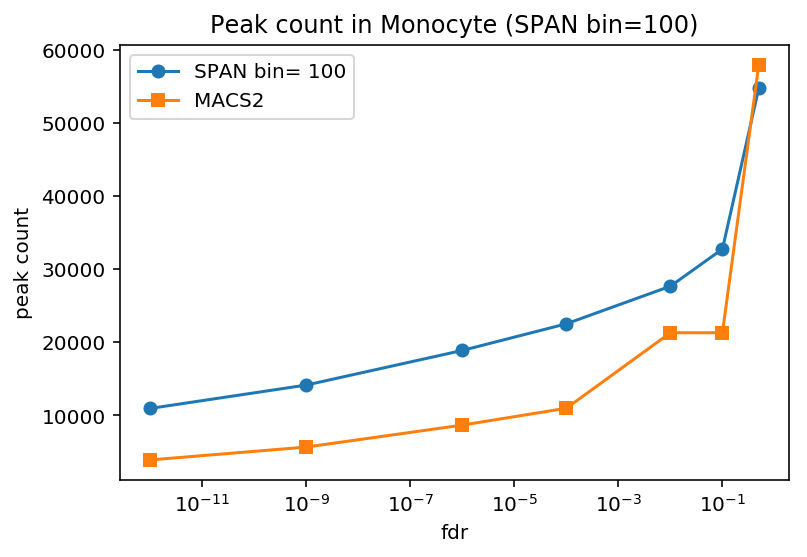

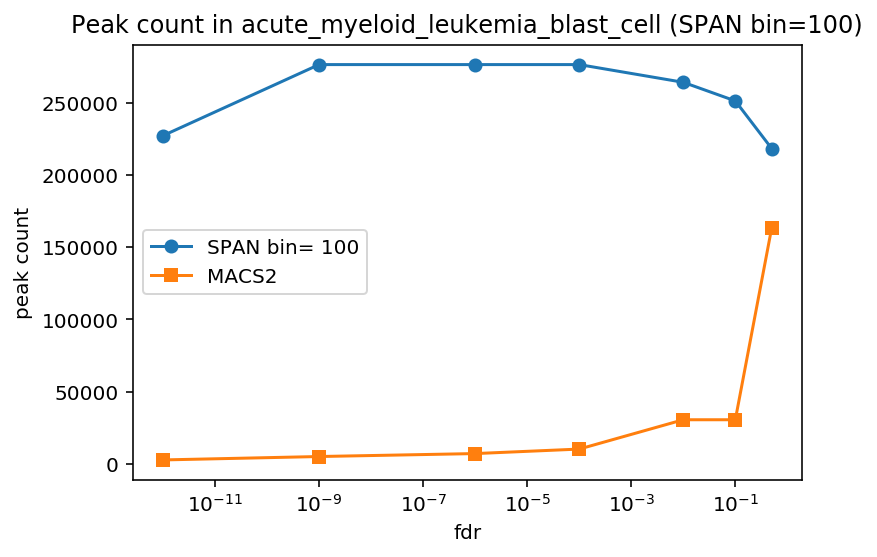

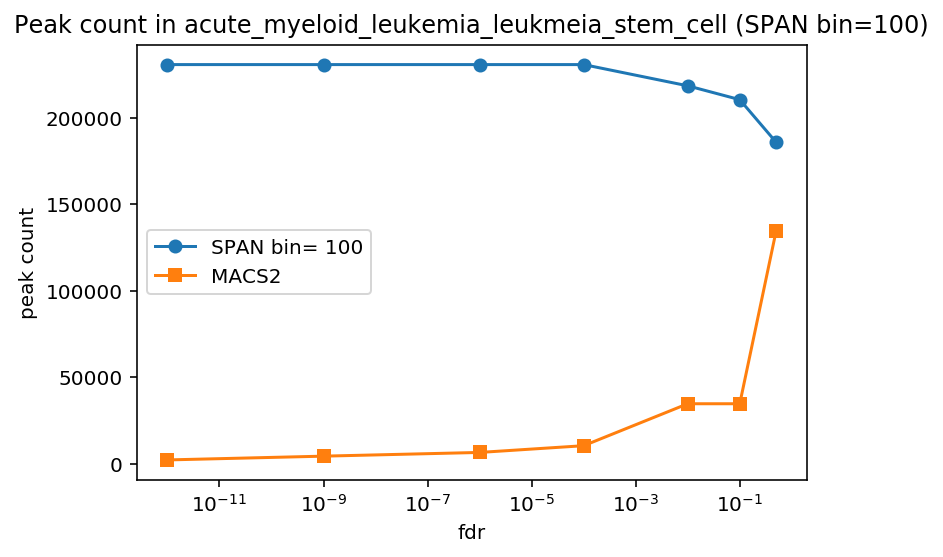

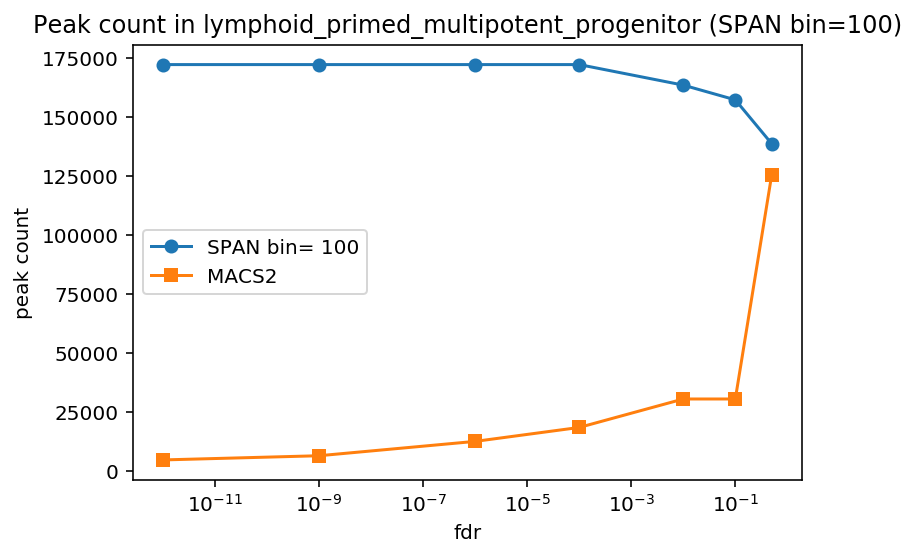

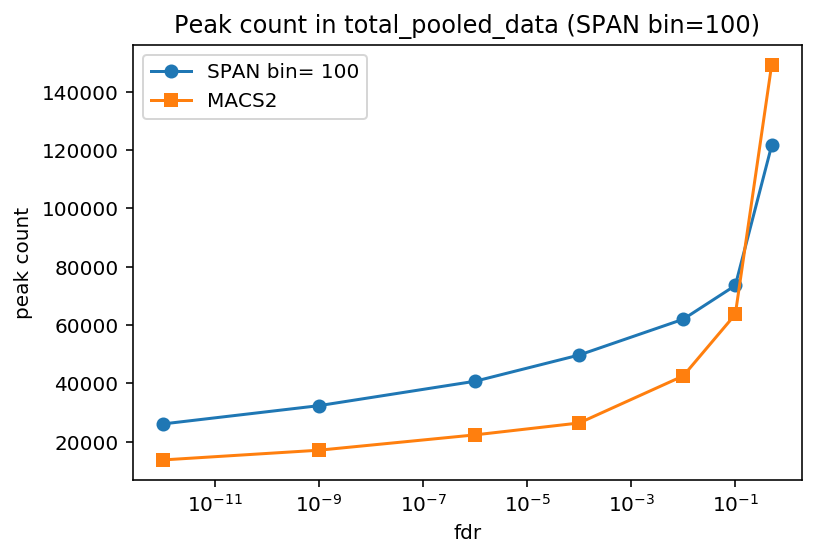

In [64]:
for cell in CELLS:
    for span_bin in SPAN_BINS:
        peak_count_dataframe = main_dataframe[
            np.logical_and(main_dataframe['cell'] == cell,
            np.logical_or(main_dataframe['peak_caller'] == 'macs2', main_dataframe['bin'] == int(span_bin)))]
        span_peak_count_5 = peak_count_dataframe[
            np.logical_and(peak_count_dataframe['peak_caller'] == 'span', peak_count_dataframe['gap'] == 5)]
        plt.plot(span_peak_count_5['q'], span_peak_count_5['peak_count'], 'o-', label='SPAN bin= ' + span_bin)

        macs2_peak_count = peak_count_dataframe[peak_count_dataframe['peak_caller'] == 'macs2']
        plt.plot(macs2_peak_count['q'], macs2_peak_count['peak_count'], 's-', label='MACS2')
        plt.xlabel('fdr')
        plt.xscale('log')
        plt.ylabel('peak count')
        plt.title('Peak count in ' + cell + ' (SPAN bin=' + span_bin + ')')        
        plt.legend()
        plt.show()

# Reworked visualization

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


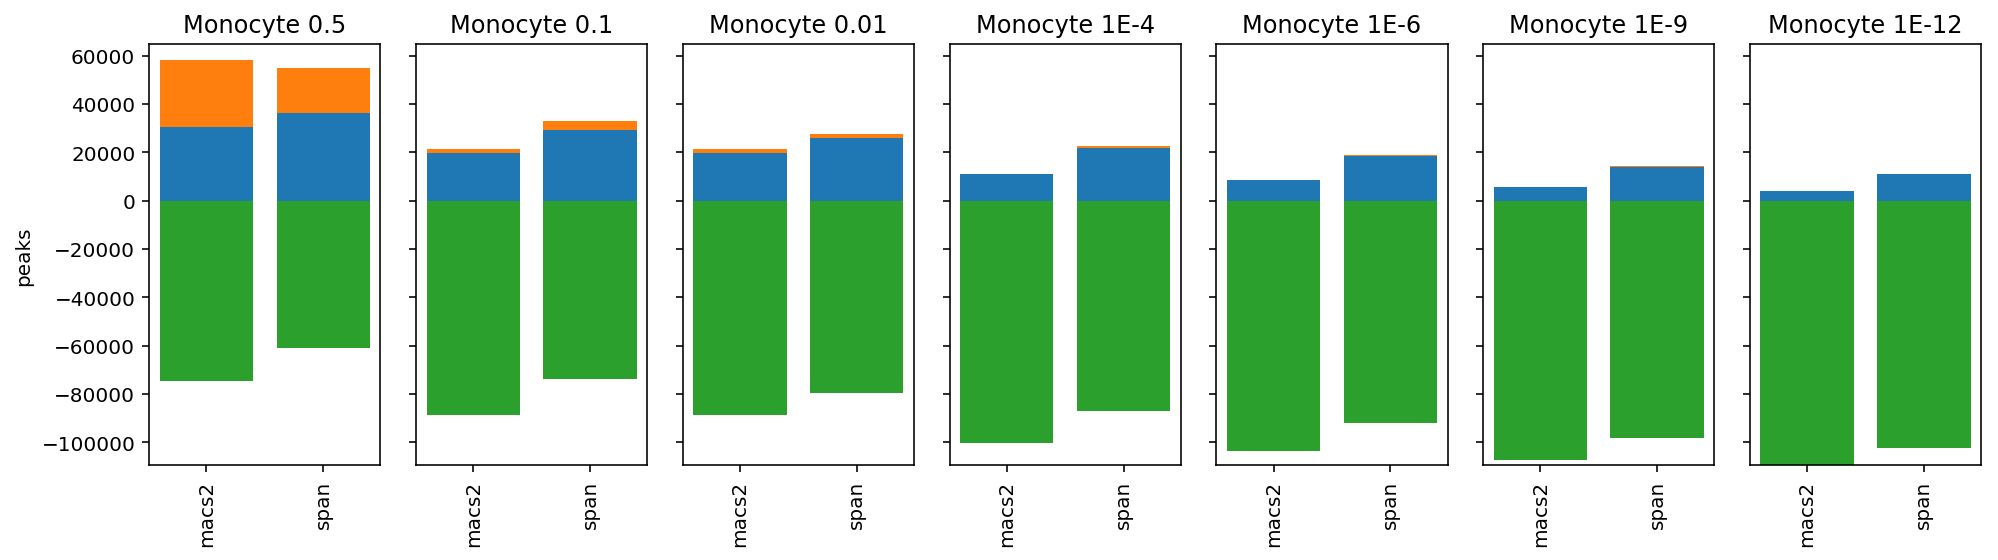

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


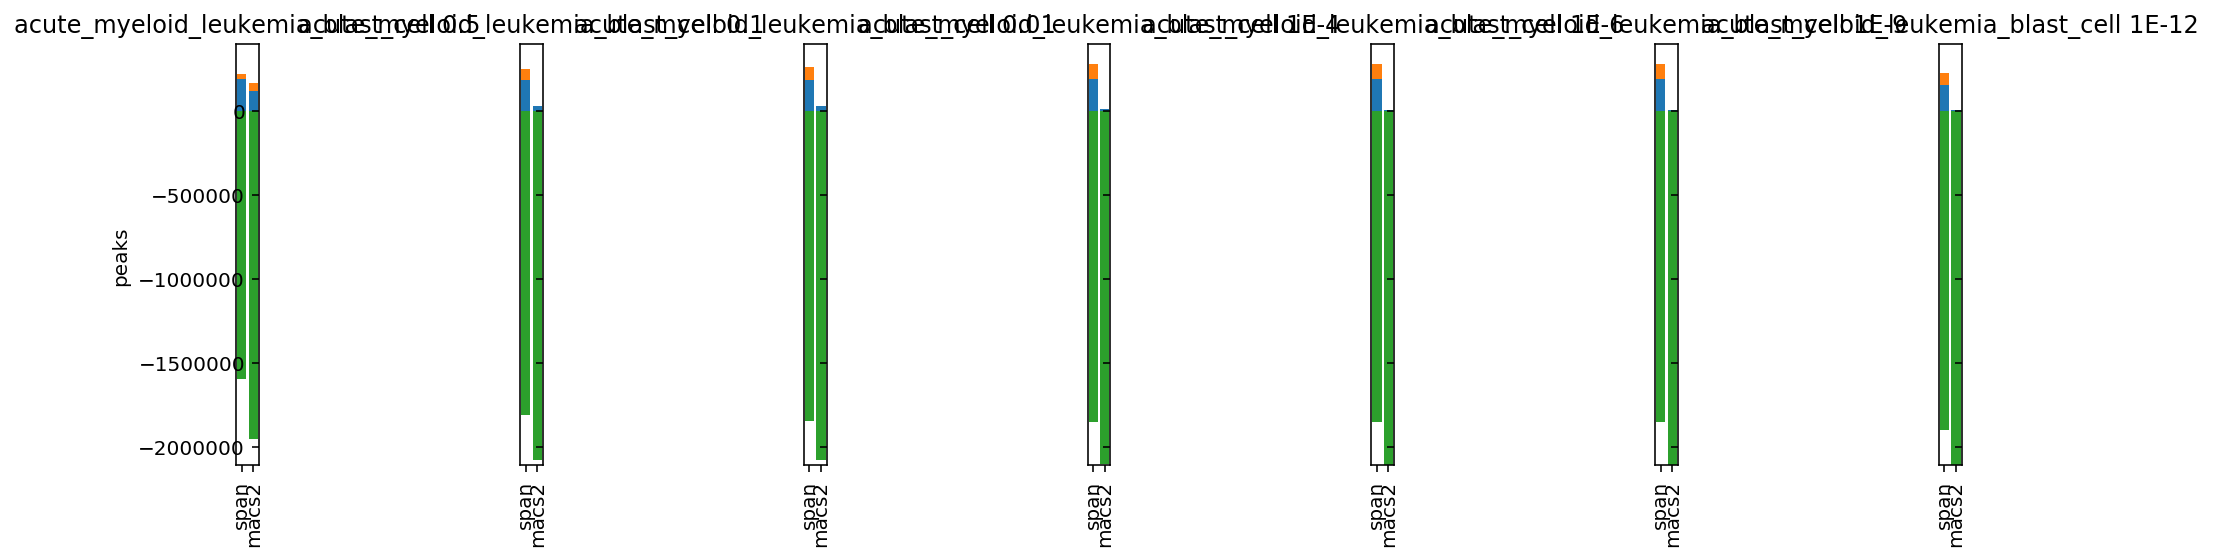

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


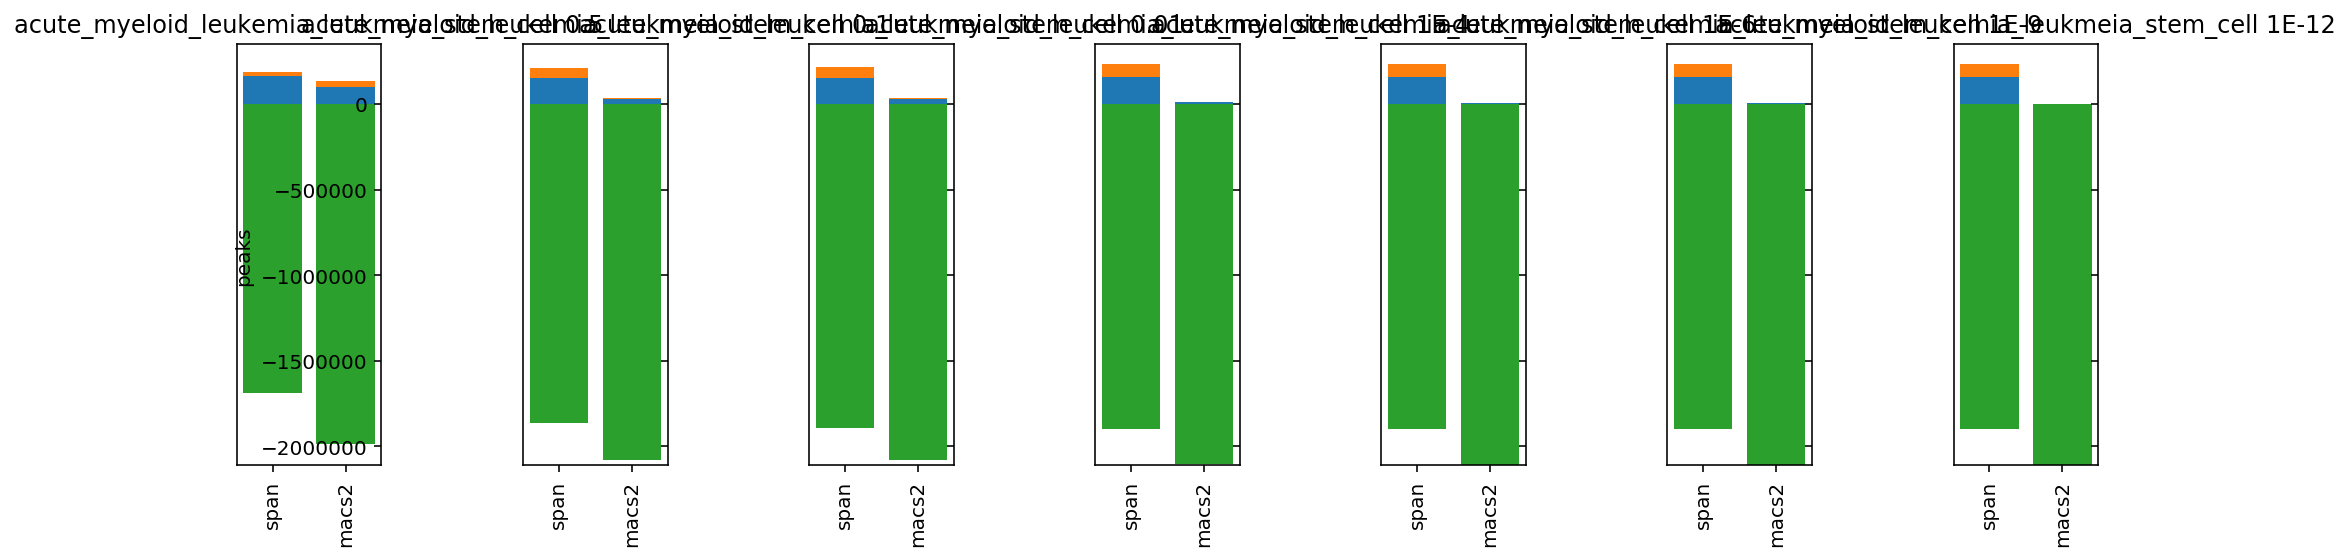

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


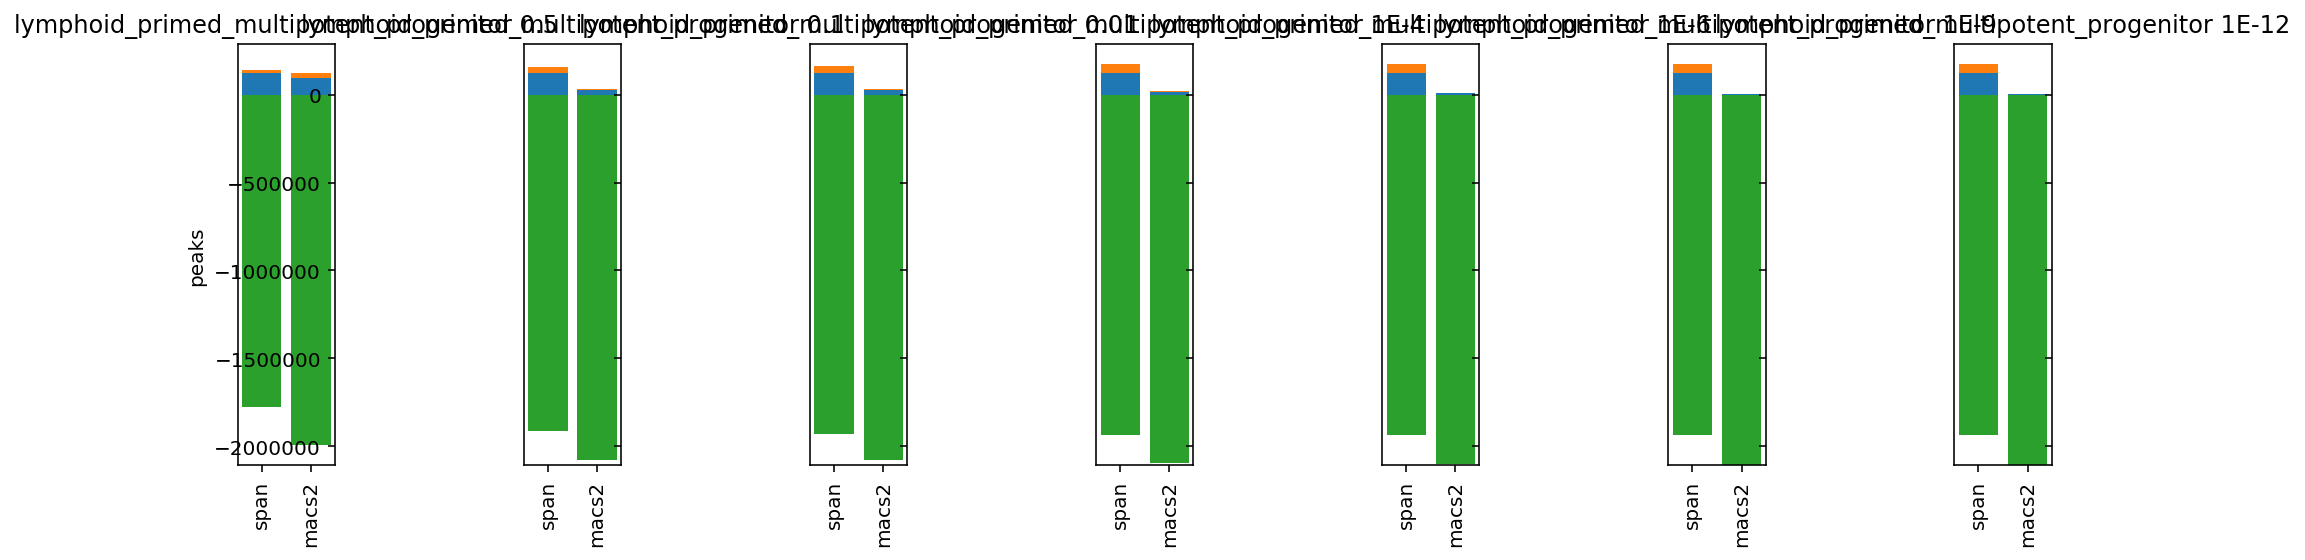

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


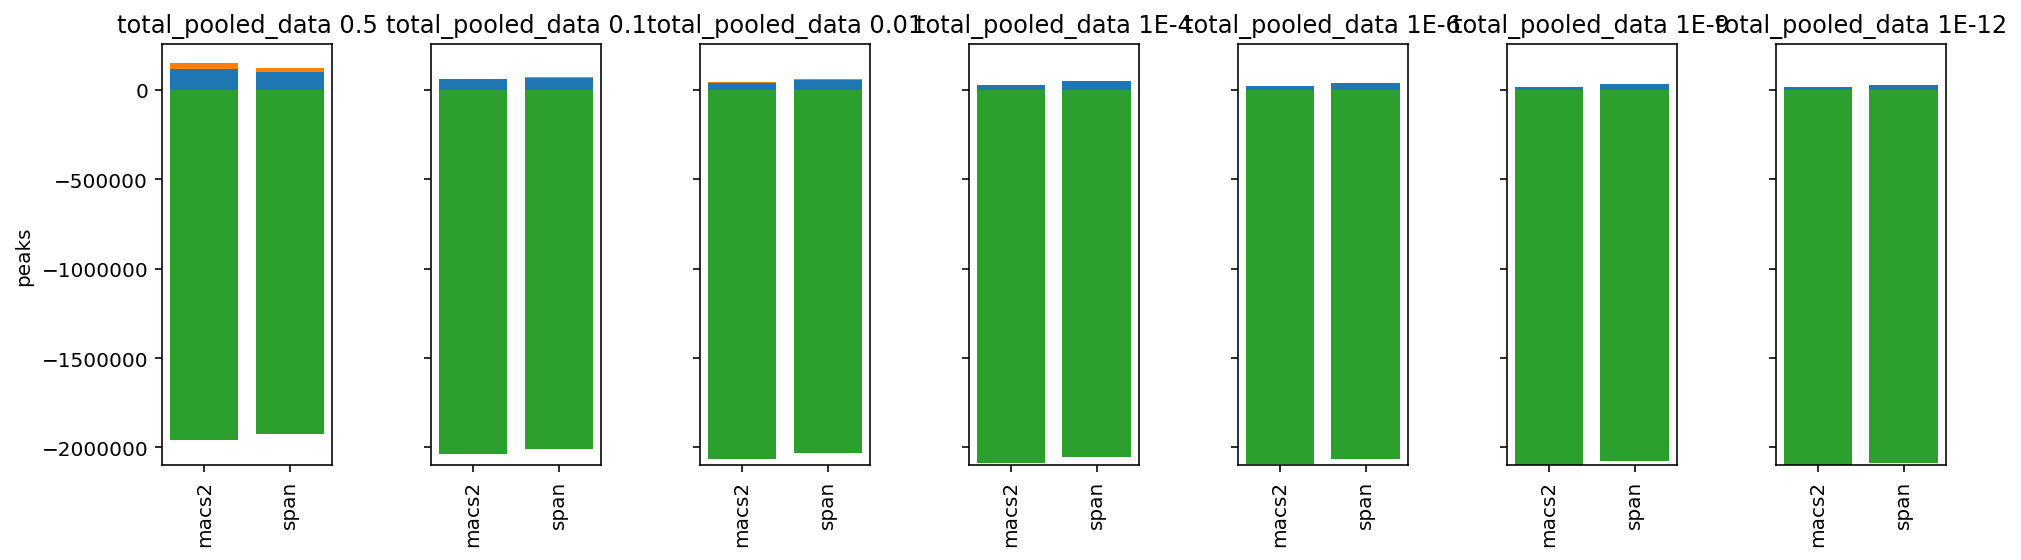

In [66]:
import seaborn as sns
for cell in CELLS:
    span_bin = "100"
    mdf = overlap_dataframe[overlap_dataframe['cell'] == cell]\
    [['peak_caller', 'q', 'peak_count', 'dhs_by_peak', 'peak_by_dhs']].copy()
    dhs_file = monocyte_dhs_file if cell == 'Monocyte' else dhs_hg19
    mdf['dhs_ex'] = (np.ones(len(mdf)) - mdf['dhs_by_peak'] / 100) * dhs_file.count()
    mdf['peaks_ex'] = (np.ones(len(mdf)) - mdf['peak_by_dhs'] / 100) * mdf['peak_count']
    mdf['both'] = mdf['peak_by_dhs'] * mdf['peak_count'] / 100

    axs = {}

    mdf['qp'] = mdf['q'].astype(str) + " " + mdf['peak_caller']
    qpl = len(set(mdf['qp']))
    fig = plt.figure(figsize=(qpl, 4))
    offset = 0
    for q in QS:
        data = mdf.loc[mdf['q'] == float(q)]
        xlabels = []
        for t in data['peak_caller']:
            if t not in xlabels:
                xlabels.append(t)
        w = len(set(data['peak_caller']))
        ax = plt.subplot2grid((1, qpl), (0, offset), colspan=w)
        p1 = ax.bar(data['peak_caller'], data['both'])
        p2 = ax.bar(data['peak_caller'], data['peaks_ex'],
                    bottom=data['both'])
        p3 = ax.bar(data['peak_caller'], data['dhs_ex'],
                    bottom=-data['dhs_ex'])

        ax.legend().set_visible(False)
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel('peaks')

        offset += w
        ax.set_xlabel('')
        ax.set_title(cell + ' ' + q)
        plt.xticks(range(0, len(xlabels)), xlabels, rotation=90)

    ymin = np.min([v[0] for v in axs.values()])
    ymax = np.max([v[1] for v in axs.values()])

    for ax in axs.keys():
        ax.set_ylim(bottom = ymin, top = ymax)
    plt.tight_layout()
    plt.show()

# True positives visualization

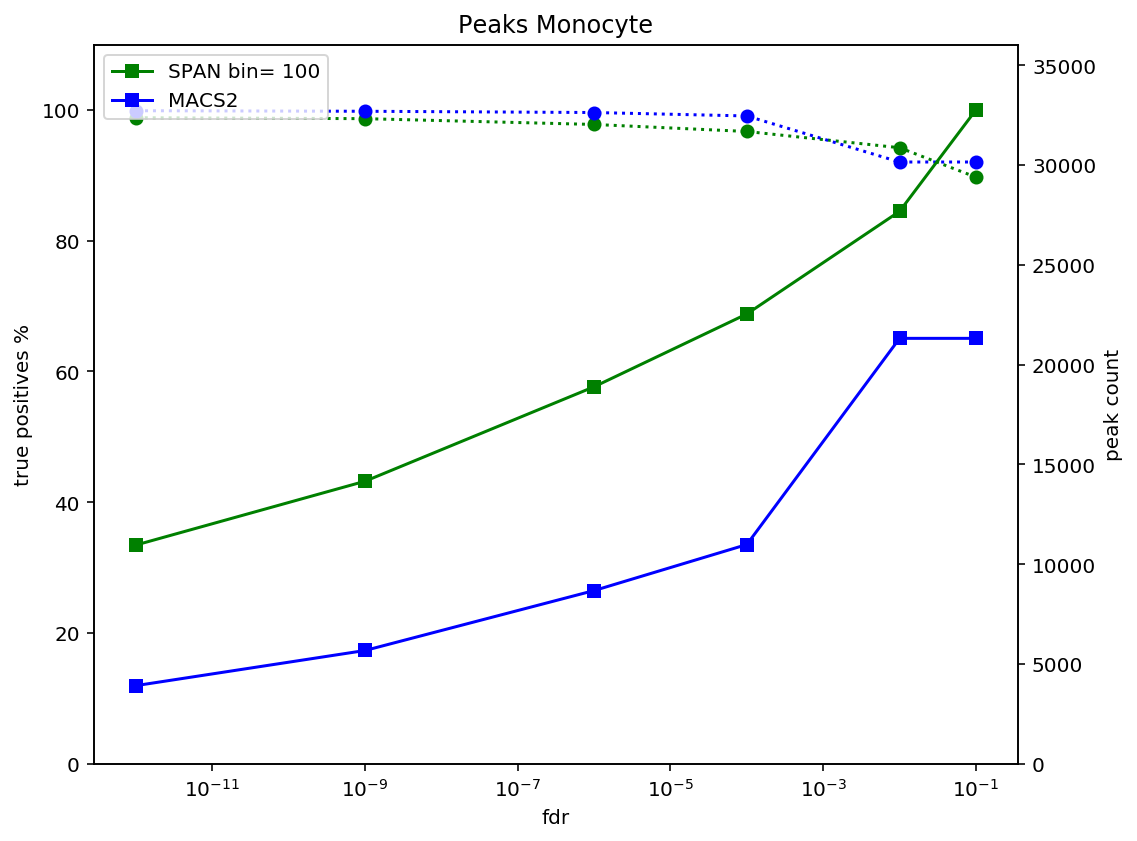

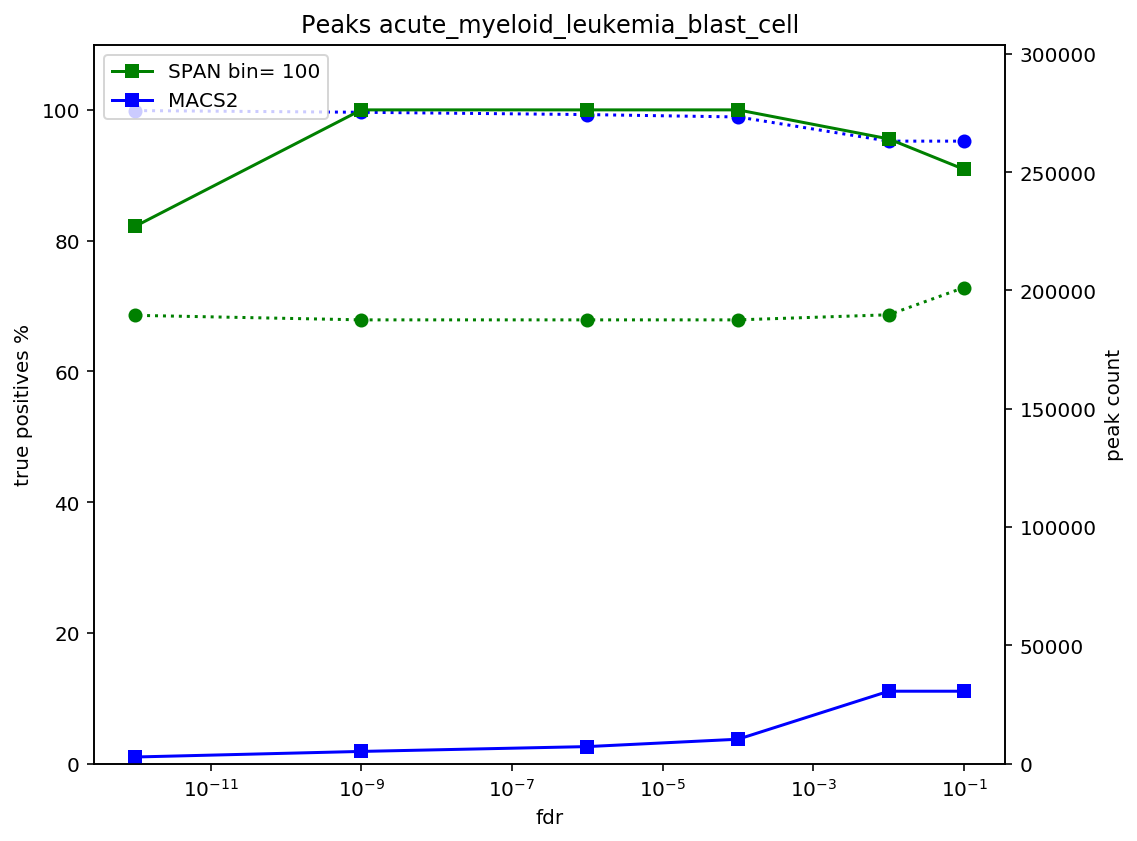

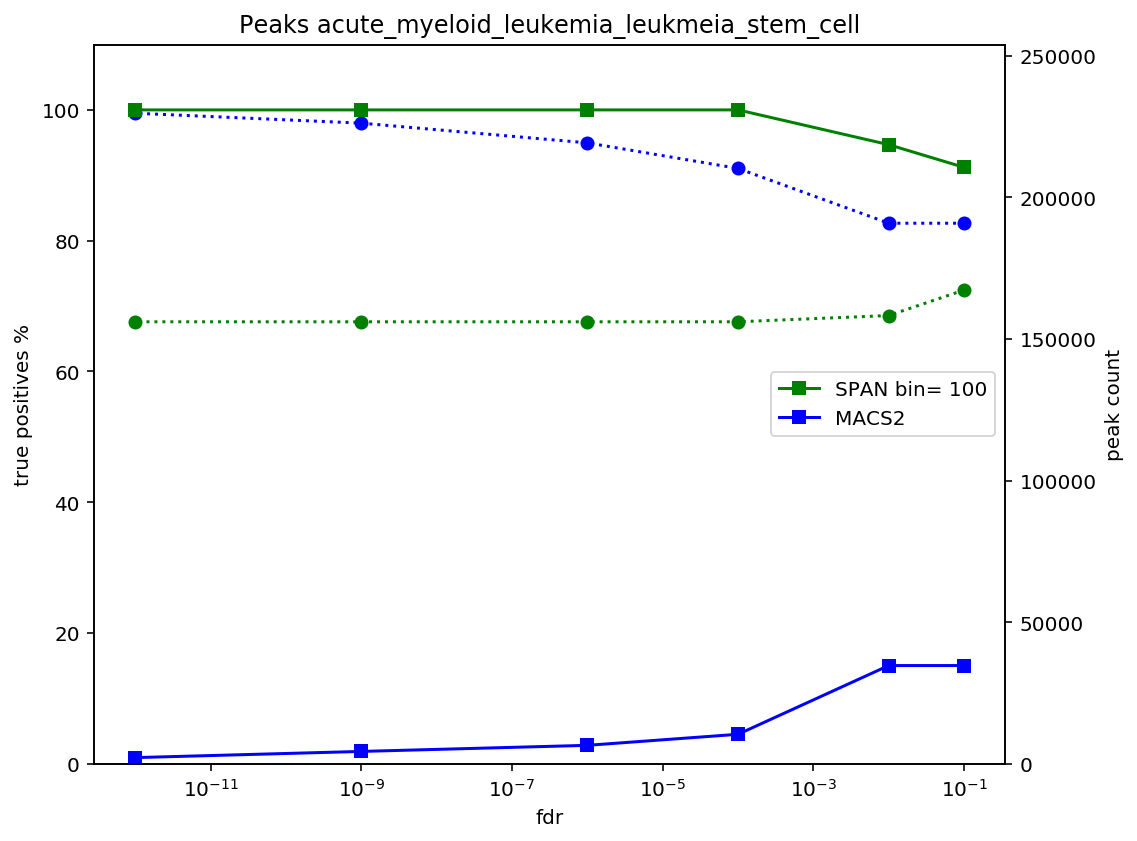

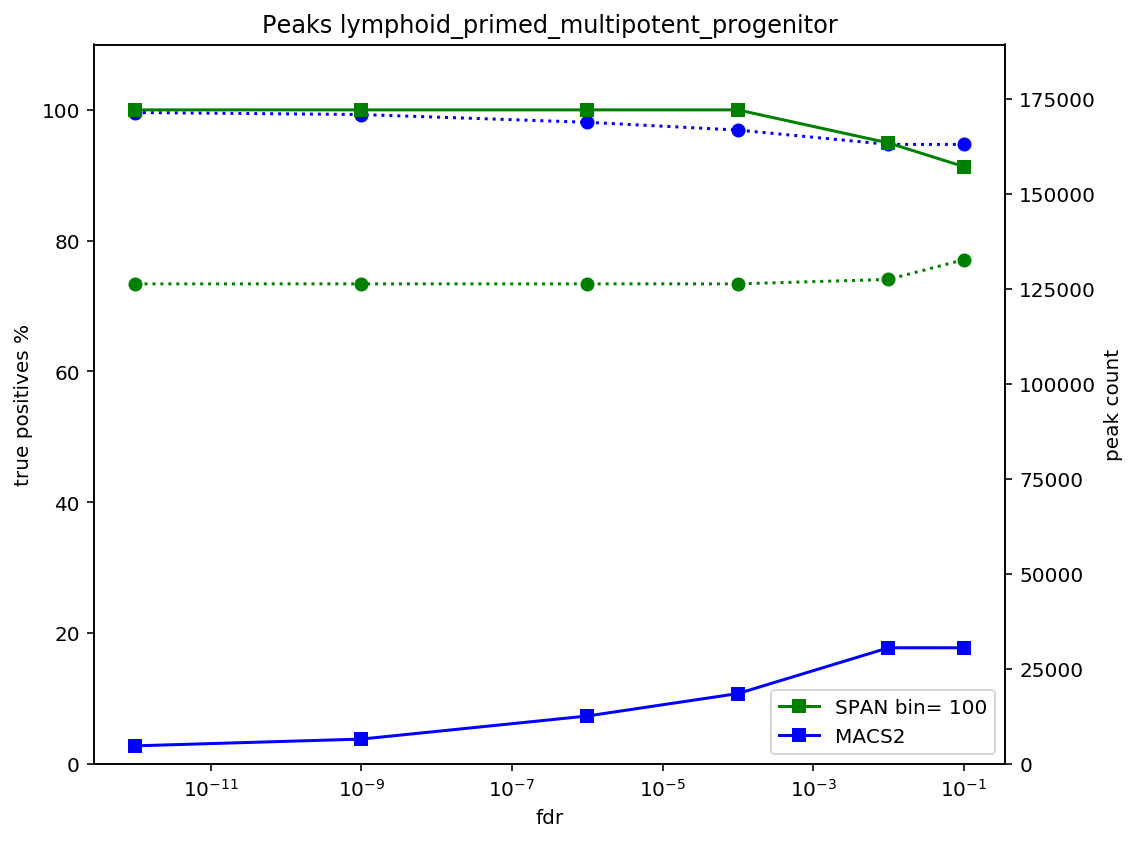

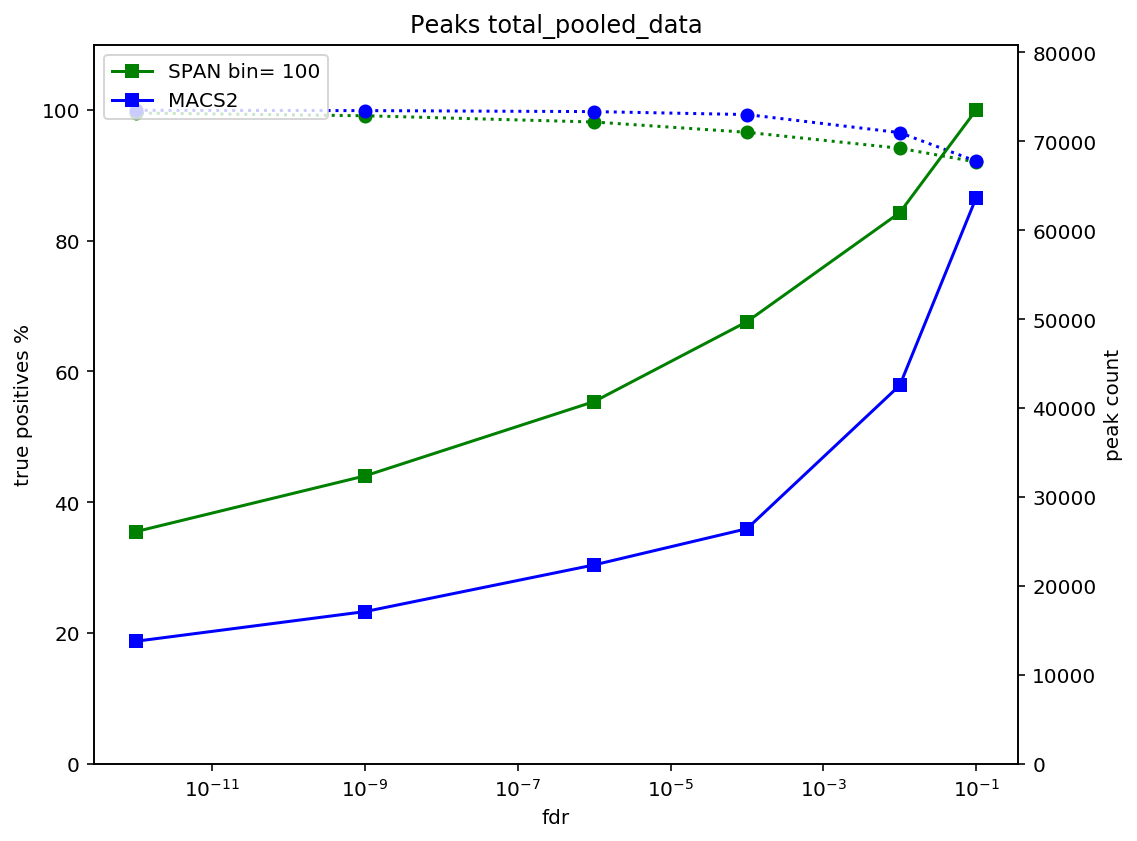

In [67]:
for cell in CELLS:
    span_bin = "100"
    peak_count_dataframe = main_dataframe[
        np.logical_and(np.logical_and(main_dataframe['cell'] == cell, main_dataframe['q'] <= 0.1),
        np.logical_or(main_dataframe['peak_caller'] == 'macs2', main_dataframe['bin'] == int(span_bin)))]
    span_peak_count_5 = peak_count_dataframe[
        np.logical_and(peak_count_dataframe['peak_caller'] == 'span', peak_count_dataframe['gap'] == 5)]
    macs2_peak_count = peak_count_dataframe[peak_count_dataframe['peak_caller'] == 'macs2']

    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.set_ylim(0, 110)
    ax1.plot(span_peak_count_5['q'], span_peak_count_5['peak_by_dhs'], 'o:', c='green', label='SPAN bin= ' + span_bin)
    ax1.plot(macs2_peak_count['q'], macs2_peak_count['peak_by_dhs'], 'o:', c='blue', label='MACS2')
    ax1.set_ylabel('true positives %')
    ax1.set_xlabel('fdr')

    ax2 = ax1.twinx()
    ax2.set_ylim(0, 1.1 * max(peak_count_dataframe['peak_count']))
    ax2.plot(span_peak_count_5['q'], span_peak_count_5['peak_count'], 's-', c='green', label='SPAN bin= ' + span_bin)
    ax2.plot(macs2_peak_count['q'], macs2_peak_count['peak_count'], 's-', c='blue', label='MACS2')
    ax2.set_xscale('log')
    ax2.set_ylabel('peak count')

    plt.title('Peaks ' + cell)        
    plt.legend()

    fig.tight_layout()
    plt.show()